# Session 8: Neural Networks

In [1]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

import copy
import torch 
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from torchviz import make_dot

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython.display import clear_output

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [3]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

While `sklearn` has a library for neural networks, it is very basic and not the standard in the industry. The most commonly used libraries as of 2020 are **Tensorflow** and **Pytorch**.

- TensorFlow is developed by Google Brain and actively used at Google both for research and production needs. Its closed-source predecessor is called DistBelief.

- PyTorch is a cousin of lua-based Torch framework which was developed and used at Facebook. However, PyTorch is not a simple set of wrappers to support popular language, it was rewritten and tailored to be fast and feel native.

Here is an article that explains very well the difference between the two libraries: [pytorch-vs-tensorflow](https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b). In short, pytorch is much more intuitive for a python programmer and more user friendly. It also has a superior development and debugging experience. However, if you want more control on the fundamentals, a better community support and you need to train large models, Tensorflow is better.

## 8.1 Introduction

[*back to index*](#/1)

The term neural network has evolved to encompass a large class of models and learning methods. Here I describe the most widely used “vanilla” neural net, sometimes called the single hidden layer back-propagation network, or single layer perceptron.

### Regression

Imagine a setting with two **inputs** available (let’s denote these inputs $i_1$ and $i_2$), and no special knowledge about the relationship between these inputs and the **output** that we want to predict (denoted by $o$) except that this relationship is, a priori, pretty complex and non-linear.

So we want to learn the function $f$ such that f($i_1$, $i_2$) is a good estimator of $o$. We could then suggest the following first model:

$$
o = w_{11} i_1 + w_{12} i_2
$$

where w11 and w12 are just weights/coefficients (do not take care about the indices for now). Before going any further, we should notice that, here, there is no constant term in the model. However, we could have introduced such term by setting $f(i_1, i_2) = w_{11} i_1 + w_{12} i_2 + c$. The constant is often called **bias**.

We can represent the setting as follows.

<img src="figures/nn1.jpeg" alt="Drawing" style="width: 600px;"/>

In this case, the model is easy to understand and to fit but has a big drawback : there is no non-linearity! This obviously do not respect our non-linear assumption. 

### Activation Functions

In order to introduce a non-linearity, let us make a little modification in the previous model and suggest the following one.

$$
o = a ( w_{11} i_1 + w_{12} i_2)
$$

where $a$ is a function called **activation function** which is non-linear.

<img src="figures/nn2.jpeg" alt="Drawing" style="width: 600px;"/>

One commonly known activation function in economics is the *sigmoid* function or logit function

$$
a (w_{11} i_1 + w_{12} i_2) = \frac{1}{1 + e^{w_{11} i_1 + w_{12} i_2}}
$$

### Layers

However, even if better than multilinear model, this model is still too simple and can’t handle the assumed underlying complexity of the relationship between inputs and output. We can make a step further and enrich the model the following way. 


1. First we could consider that the quantity $a ( w_{11} i_1 + w_{12} i_2)$ is no longer the final output but instead a new intermediate feature of our function, called $l_1$, which stands for **layer**. 

$$
l_1 = a ( w_{11} i_1 + w_{12} i_2)
$$

2. Second we could consider that we build several (3 in our example) such features in the same way, but possibly with different weights and different activation functions

$$
l_1 = a ( w_{11} i_1 + w_{12} i_2) \\
l_2 = a ( w_{21} i_1 + w_{22} i_2) \\
l_3 = a ( w_{31} i_1 + w_{32} i_2) 
$$

where the $a$’s are just activation functions and the $w$’s are weights. 
    

3. Finally, we can consider that our final output is build based on these intermediate features with the same “template”

$$
a_2 ( v_1 l_1 + v_2 l_2 + v_3 * l_3 )
$$

If we aggregate all the pieces, we then get our **prediction** $p$

$$
\begin{aligned}
p = f_{3}\left(i_{1}, i_{2}\right) &=a_{2}\left(v_{1} l_{1}+v_{2} l_{2}+v_{3} l_{3}\right) \\
&=a_{2}\left(v_{1} \times a_{11}\left(w_{11} i_{1}+w_{12} i_{2}\right)+v_{2} \times a_{12}\left(w_{21} i_{1}+w_{22} i_{2}\right)+v_{3} \times a_{13}\left(w_{31} i_{1}+w_{32} i_{2}\right)\right)
\end{aligned}
$$

where we should mainly keep in mind that $a$’s are non-linear activation functions and $w$’s and $v$’s are weights.

Graphically:

<img src="figures/nn3.jpeg" alt="Drawing" style="width: 900px;"/>

This last model is a basic feedforward neural network with:
 - 2 entries ($i_1$ and $i_2$)
 - 1 hidden layer with 3 hidden neurones (whose outputs are $l_1$, $l_2$ and $l_3$)
 - 1 final output ($p$)

## Pytorch

[*back to index*](#/1)

### Tensors

We can express the data as a `numpy` array.

In [4]:
x_np = np.arange(6).reshape((3, 2))
x_np

array([[0, 1],
       [2, 3],
       [4, 5]])

Or equivalently as a `pytorch` tensor.

In [5]:
x_tensor = torch.from_numpy(x_np)
x_tensor

tensor([[0, 1],
        [2, 3],
        [4, 5]])

We can also translate tensors back to arrays.

In [6]:
tensor2array = x_tensor.numpy()
tensor2array

array([[0, 1],
       [2, 3],
       [4, 5]])

We can make operations over this data. For example we can take the mean

In [7]:
try:
    torch.mean(x_tensor)
except Exception as e:
    print(e)

Can only calculate the mean of floating types. Got Long instead.


We first have to convert the data in float

In [8]:
x_tensor = torch.FloatTensor(x_np)
x_tensor

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])

In [9]:
print(np.mean(x_np), '\n\n', torch.mean(x_tensor))

2.5 

 tensor(2.5000)


We can also apply compontent-wise functions

In [10]:
print(np.sin(x_np), '\n\n', torch.sin(x_tensor))

[[ 0.          0.84147098]
 [ 0.90929743  0.14112001]
 [-0.7568025  -0.95892427]] 

 tensor([[ 0.0000,  0.8415],
        [ 0.9093,  0.1411],
        [-0.7568, -0.9589]])


We can multiply tensors as we multiply matrices

In [11]:
print(np.matmul(x_np.T, x_np), '\n\n', torch.mm(x_tensor.T, x_tensor))

[[20 26]
 [26 35]] 

 tensor([[20., 26.],
        [26., 35.]])


But the element-wise multiplication does not work

In [12]:
try:
    x_tensor.dot(x_tensor)
except Exception as e:
    print(e)

1D tensors expected, but got 2D and 2D tensors


### Variables

Variable in torch is to build a computational graph, but this graph is dynamic compared with a static graph in Tensorflow or Theano. So torch does not have placeholder, torch can just pass variable to the computational graph.

In [13]:
# build a variable, usually for compute gradients
x_variable = Variable(x_tensor, requires_grad=True)   

x_variable

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]], requires_grad=True)

Until now the tensor and variable seem the same. However, the variable is a part of the graph, it's a part of the auto-gradient.

Suppose we are interested in: 

$$
y = \text{mean} (x_1^2) = \frac{1}{6} x^2
$$

In [14]:
y = torch.mean(x_variable*x_variable)
print(y)

tensor(9.1667, grad_fn=<MeanBackward0>)


We can compute the gradient by backpropagation

$$
\nabla y(x) = \frac{2}{3} x
$$

i.e. if we call the `backward` method on our outcome `y`, we see that the gradient of our variable `x` gets updated.

In [15]:
print(x_variable.grad)

None


In [16]:
y.backward()

In [17]:
print(x_variable.grad)

tensor([[0.0000, 0.3333],
        [0.6667, 1.0000],
        [1.3333, 1.6667]])


However, its value has not changed.

In [18]:
print(x_variable)

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]], requires_grad=True)


We can also access the `tensor` part of the variable alone by calling the `data` method.

In [19]:
print(x_variable.data)

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])


### Activation function

The main advantage of neural networks is that they introduce non-linearities among the layers. The standard non-linear function 

- ReLu
- Sigmoid
- TanH
- Softmax

In [20]:
# X grid
x_grid = torch.linspace(-5, 5, 200)  # x data (tensor), shape=(100, 1)
x_grid = Variable(x_grid)
x_grid_np = x_grid.data.numpy()   # numpy array for plotting

# Activation functions
y_relu = torch.relu(x_grid).data.numpy()
y_sigmoid = torch.sigmoid(x_grid).data.numpy()
y_tanh = torch.tanh(x_grid).data.numpy()
y_softmax = torch.softmax(x_grid, dim=0).data.numpy() 

In [21]:
# New figure 1
def make_new_figure_1():

    # Init figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,6))
    fig.suptitle('Activation Functions')

    # Relu
    ax1.plot(x_grid_np, y_relu, c='red', label='relu')
    ax1.set_ylim((-1, 6)); ax1.legend()

    # Sigmoid
    ax2.plot(x_grid_np, y_sigmoid, c='red', label='sigmoid')
    ax2.set_ylim((-0.2, 1.2)); ax2.legend()

    # Tanh
    ax3.plot(x_grid_np, y_tanh, c='red', label='tanh')
    ax3.set_ylim((-1.2, 1.2)); ax3.legend()

    # Softmax
    ax4.plot(x_grid_np, y_softmax, c='red', label='softmax')
    ax4.set_ylim((-0.01, 0.06)); ax4.legend();

Let's compare the different activation functions.

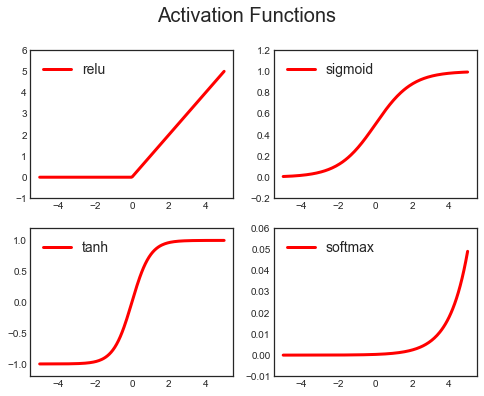

In [22]:
make_new_figure_1()

ReLu is very popular since it's non-linear.

## 8.3 Optimization and Gradient Descent

[*back to index*](#/1)

### Gradient Descent

Gradient descent works as follows:

0. Initialize the parameters
1. Compute the Loss
2. Compute the Gradients
3. Update the Parameters
4. Repeat (1)-(3) until convergence

### Gradient Descent in Linear Regression

In order to understand how are NN optimized, we start with a linear regression example. Remember that linear regression can be interpreted as the simplest possible NN.

We generate the following data:

$$
y = 1 + 2 x - 3 x^2 + \varepsilon
$$

with $x \sim N(0,1)$ and $\varepsilon \sim N(0,0.1)$

In [23]:
# Data Generation
np.random.seed(42)
N = 100

x = np.sort(np.random.rand(N, 1), axis=0)
e = .1*np.random.randn(N, 1)
y_true = 1 + 2*x - 3*x**2
y = y_true + e

Let's plot the data.

In [24]:
# New figure 2
def make_new_figure_2():
    
    # Init
    fig, ax = plt.subplots(figsize=(8,6))
    fig.suptitle('Activation Functions')

    # Scatter
    ax.scatter(x,y); 
    ax.plot(x,y_true,color='orange'); 
    ax.set_xlabel('X'); ax.set_ylabel('Y');
    ax.legend(['y true','y']);

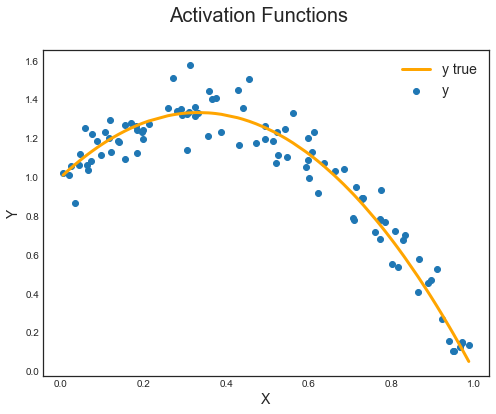

In [25]:
make_new_figure_2()

Suppose we try to fit the data with a linear model

$$
y = a + b x
$$

We proceed iteratively by gradient descent. Our objective function is the Mean Squared Error.

**Algorithm**

0. Take an initial guess of the parameters
    $$
    a = a_0 \\
    b = b_0
    $$

1. Compute the Mean Squared Error
    $$
    \begin{array}
    \text{MSE} &= \frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2} \\
          &= \frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-a-b x_{i}\right)^{2}
    \end{array}
    $$
    
2. Compute its derivative
    $$
    \begin{array}{l}
    \frac{\partial M S E}{\partial a}=\frac{\partial M S E}{\partial \hat{y}_{i}} \cdot \frac{\partial \hat{y}_{i}}{\partial a}=\frac{1}{N} \sum_{i=1}^{N} 2\left(y_{i}-a-b x_{i}\right) \cdot(-1)=-2 \frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right) \\
    \frac{\partial M S E}{\partial b}=\frac{\partial M S E}{\partial \hat{y}_{i}} \cdot \frac{\partial \hat{y}_{i}}{\partial b}=\frac{1}{N} \sum_{i=1}^{N} 2\left(y_{i}-a-b x_{i}\right) \cdot\left(-x_{i}\right)=-2 \frac{1}{N} \sum_{i=1}^{N} x_{i}\left(y_{i}-\hat{y}_{i}\right)
    \end{array}
    $$
    
3. Update the parameters 
    $$
        \begin{array}{l}
        a=a-\eta \frac{\partial M S E}{\partial a} \\
        b=b-\eta \frac{\partial M S E}{\partial b}
        \end{array}
    $$
    
    Where $\eta$ is the **learning rate**. A lower learning rate makes learning more stable but slower.

4. Repeat (1)-(3) $T$ times, where the number of total iterations $T$ is called **epochs**.

We start by taking a random guess of $\alpha$ and $\beta$.

In [26]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

[0.49671415] [-0.1382643]


In [27]:
# Plot gradient 
def gradient_plot(x, y, y_hat, y_true, EPOCHS, losses):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    
    # First figure
    ax1.clear()
    ax1.scatter(x, y)
    ax1.plot(x, y_true, 'orange')
    ax1.plot(x, y_hat, 'r-')
    ax1.set_title('Data and Fit')
    ax1.legend(['True', 'Predicted'])
    
    # Second figure
    ax2.clear()
    ax2.plot(range(len(losses)), losses, color='g')
    ax2.set_xlim(0,EPOCHS); ax2.set_ylim(0,1.1*np.max(losses))
    ax2.set_title('True MSE = %.4f' % losses[-1])
    
    # Plot
    plt.show();

We set the learning rate $\eta = 0.1$ and the number of epochs $T=200$

In [28]:
# parameters
LR = 0.1        # learning rate
EPOCHS = 200    # number of epochs

We can now plot the training and the result.

In [29]:
# New figure 3
def make_new_figure_3(a, b):
    
    # Init
    losses = []

    # train
    for t in range(EPOCHS):

        # compute loss
        y_hat = a + b * x
        error = (y - y_hat)
        loss = (error**2).mean()

        # compute gradient
        a_grad = -2 * error.mean()
        b_grad = -2 * (x * error).mean()

        # update parameters
        a -= LR * a_grad
        b -= LR * b_grad

        # plot
        losses += [loss]
        if (t+1) % (EPOCHS/25) == 0: # print 25 times
            gradient_plot(x, y, y_hat, y_true, EPOCHS, losses)

    print(a, b)

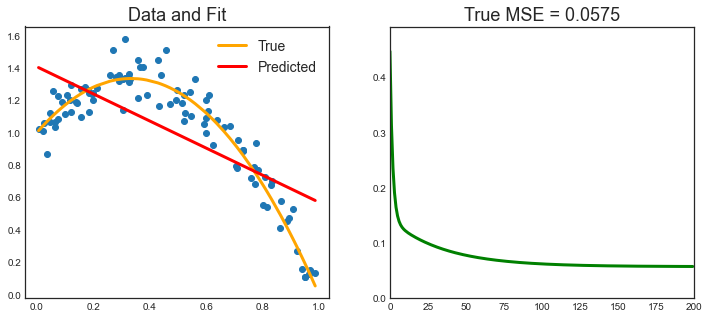

[1.40589939] [-0.83739496]


TypeError: cannot unpack non-iterable NoneType object

In [30]:
a_fit, b_fit = make_new_figure_3(a, b)

Sanity Check: do we get the same results as our gradient descent?

In [ ]:
# OLS estimates
ols = LinearRegression()
ols.fit(x, y)
print(ols.intercept_, ols.coef_[0])

Close enough!

Let's plot both lines in the graph.

In [ ]:
# New figure 4
def make_new_figure_4():
    
    # Init
    fig, ax = plt.subplots(figsize=(8,6))

    # Scatter
    ax.plot(x,y_true,color='orange'); 
    ax.plot(x,a_fit + b_fit*x,color='red'); 
    ax.plot(x,ols.predict(x),color='green'); 
    ax.legend(['y true','y gd', 'y ols'])
    ax.scatter(x,y); 
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_title("Data");

In [ ]:
make_new_figure_4()

Now we are going to do exactly the same but with `pytorch`.

### Autograd

Autograd is PyTorch’s automatic differentiation package. Thanks to it, we don’t need to worry about partial derivatives, chain rule or anything like it.

So, how do we tell PyTorch to do its thing and compute all gradients? That’s what `backward()` is good for.
§
Do you remember the starting point for computing the gradients? It was the loss, as we computed its partial derivatives w.r.t. our parameters. Hence, we need to invoke the `backward()` method from the corresponding Python variable, like, `loss.backward()`.

What about the actual values of the gradients? We can inspect them by looking at the grad attribute of a tensor.

If you check the method’s documentation, it clearly states that gradients are accumulated. So, every time we use the
gradients to update the parameters, we need to zero the gradients afterwards. And that’s what zero_() is good for.

What does the underscore (_) at the end of the method name mean? Do you remember? If not, scroll back to the previous section and find out.

So, let’s ditch the manual computation of gradients and use both backward() and zero_() methods instead.

First, we convert our variables to tensors.

In [ ]:
# Convert data to tensors
x_tensor = torch.from_numpy(x).float().to('cpu')
y_tensor = torch.from_numpy(y).float().to('cpu')
print(type(x), type(x_tensor))

We take the initial parameters guess

In [ ]:
# initial parameter guess
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')
b = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')

Now we are ready to fit the model.

In [ ]:
# New figure 5
def make_new_figure_5(a, b):
    
    # Init
    losses = []

    # parameters
    LR = 0.1
    EPOCHS = 200

    # train
    for t in range(EPOCHS):

        # compute loss
        y_hat = a + b * x_tensor
        error = y_tensor - y_hat
        loss = (error ** 2).mean()

        # compute gradient
        loss.backward()

        # update parameters
        with torch.no_grad():
            a -= LR * a.grad
            b -= LR * b.grad

        # clear gradients
        a.grad.zero_()
        b.grad.zero_()

        # Plot
        losses += [((y_true - y_hat.detach().numpy())**2).mean()]
        if (t+1) % (EPOCHS/25) == 0: # print 25 times
            gradient_plot(x, y, y_hat.data.numpy(), y_true, EPOCHS, losses)

    print(a, b)

In [ ]:
make_new_figure_5(a, b)

### Optimizer


So far, we’ve been manually updating the parameters using the computed gradients. That’s probably fine for two parameters… but what if we had a whole lot of them?! We use one of PyTorch’s optimizers.

An optimizer takes the following arguments:

- the parameters we want to update
- he learning rate we want to use
- (possibly many other hyper-parameters)

Moreover, we can now call the function `zero_grad()` to automatically update the parameters. In particular, we will need to perform the following steps at each iteration:

- Clear the parameters: `optimizer.zero_grad()`
- Compute the gradient: `loss.backward()`
- Update the parameters: `optimizer.step()`

In the code below, we create a Stochastic Gradient Descent (`SGD`) optimizer to update our parameters $a$ and $b$.

In [ ]:
# Init parameters
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')
b = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')

# Defines a SGD optimizer to update the parameters
optimizer = torch.optim.SGD([a, b], lr=LR)
print(optimizer)

We can also define a default loss function so that we don't have to compute it by hand. We are going to use the `MSE` loss function.

In [ ]:
# Define a loss function
loss_func = torch.nn.MSELoss()
print(loss_func)

Let's plot the estimator and the MSE.

In [ ]:
# New figure 6
def make_new_figure_6(a, b):
    
    # parameters
    EPOCHS = 200

    # init 
    losses = []

    # train
    for t in range(EPOCHS):

        # compute loss
        y_hat = a + b * x_tensor
        error = y_tensor - y_hat
        loss = (error ** 2).mean()  

        # update parameters
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients, update parameters

        # Plot
        losses += [((y_true - y_hat.detach().numpy())**2).mean()]
        if (t+1) % (EPOCHS/25) == 0:
            gradient_plot(x, y, y_hat.data.numpy(), y_true, EPOCHS, losses)

    print(a, b)

In [ ]:
make_new_figure_6(a, b)

### Building a NN

In our model, we manually created two parameters to perform a linear regression. Let’s use PyTorch’s `Sequential` module to create our neural network.

We first want to build the linear regression framework

$$
y = a + b x
$$

Which essentially is a network with
 - 1 input
 - no hidden layer
 - no activation function
 - 1 output

Let's build the simplest possible neural network with `PyTorch`.

In [ ]:
# Simplest possible neural network
linear_net = torch.nn.Sequential(
    torch.nn.Linear(1, 1)
)

print(linear_net)

Now, if we call the `parameters()` method of this model, PyTorch will figure the parameters of its attributes in a recursive way. 

In [ ]:
[*linear_net.parameters()]

We can now define the definitive training function.

In [ ]:
def train_NN(x, y, y_true, net, optimizer, loss_func, EPOCHS):
    
    # transform variables
    x_tensor = torch.from_numpy(x).float().to('cpu')
    y_tensor = torch.from_numpy(y).float().to('cpu')

    # init 
    losses = []
    
    # train
    for t in range(EPOCHS):        

        # compute loss
        y_hat = net(x_tensor)     
        loss = loss_func(y_hat, y_tensor)    
        
        # update parameters
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients, update parameters

        # plot
        losses += [((y_true - y_hat.detach().numpy())**2).mean()]
        if (t+1) % (EPOCHS/25) == 0: # print 25 times
            gradient_plot(x, y, y_hat.data.numpy(), y_true, EPOCHS, losses)

Now we are ready to train our neural network.

In [ ]:
optimizer = torch.optim.SGD(linear_net.parameters(), lr=LR)

# train
train_NN(x, y, y_true, linear_net, optimizer, loss_func, EPOCHS)

We now define a more complicated NN. In particular we, build a neural network with
 - 1 input
 - 1 hidden layer with 10 neurons and Relu activation function
 - 1 output layer

In [ ]:
# Relu Net
relu_net = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

print(relu_net)

This network has much more parameters.

In [ ]:
[*relu_net.parameters()]

We are again using Stochastic Gradient Descent (`SGD`) as optimization algorithm and Mean Squared Error (`MSELoss`) as objective function.

In [ ]:
# parameters
LR = 0.1
EPOCHS = 1000

# optimizer and loss function
optimizer = torch.optim.SGD(relu_net.parameters(), lr=LR)
loss_func = torch.nn.MSELoss()

# Train
train_NN(x, y, y_true, relu_net, optimizer, loss_func, EPOCHS)

It seems that we can use fewer nodes to get the same result.

Let's make a smallet network.

In [ ]:
# Relu Net
relu_net2 = torch.nn.Sequential(
    torch.nn.Linear(1, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1)
)

And train it.

In [ ]:
# parameters
LR = 0.1
EPOCHS = 1000

# optimizer and loss function
optimizer = torch.optim.SGD(relu_net2.parameters(), lr=LR)
loss_func = torch.nn.MSELoss()

# Train
train_NN(x, y, y_true, relu_net2, optimizer, loss_func, EPOCHS)

We can try different activation functions.

For example the tangent.

In [ ]:
# TanH Net
tanh_net = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 1)
)

In [ ]:
# parameters
LR = 0.2
EPOCHS = 1000

# optimizer and loss function
optimizer = torch.optim.SGD(tanh_net.parameters(), lr=LR)
loss_func = torch.nn.MSELoss()

# train
train_NN(x, y, y_true, tanh_net, optimizer, loss_func, EPOCHS)

### Loss functions

So far we have used the Stochastic  as loss function.

Notice that `nn.MSELoss` actually creates a loss function for us — it is NOT the loss function itself. Moreover, you can specify a reduction method to be applied, that is, how do you want to aggregate the results for individual points — you can average them (reduction=`mean`) or simply sum them up (reduction=`sum`).

We are now going to use different ones.

In [ ]:
# parameters
LR = 0.1
EPOCHS = 25

# nets
n = torch.nn.Sequential(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1))
nets = [n,n,n,n]

# optimizers
optimizers = [torch.optim.SGD(n.parameters(), lr=LR) for n in nets]

# different loss functions
loss_MSE        = torch.nn.MSELoss()
loss_L1         = torch.nn.L1Loss()
loss_NLL        = torch.nn.NLLLoss()
loss_KLD        = torch.nn.KLDivLoss()
loss_funcs = [loss_MSE, loss_L1, loss_NLL, loss_KLD]

This is the description of the loss functions:

 - `MSELoss`: Creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input $x$ and target $y$.
 
 - `L1Loss`: Creates a criterion that measures the mean absolute error (MAE) between each element in the input $x$ and target $y$.
 
 - `NLLLoss`: The negative log likelihood loss.
 
 - `KLDivLoss`: The Kullback-Leibler divergence loss measure

In [ ]:
# Train multiple nets
def train_nets(x, y, y_true, nets, optimizers, loss_funcs, labels, EPOCHS):

    # Put dateset into torch dataset
    x_tensor = torch.from_numpy(x).float().to('cpu')
    y_tensor = torch.from_numpy(y).float().to('cpu')
    torch_dataset = Data.TensorDataset(x_tensor, y_tensor)
    
    # Init
    losses = np.zeros((0,4))
    
    # Train
    for epoch in range(EPOCHS): # for each epoch
        losses = np.vstack((losses, np.zeros((1,4))))
        for k, net, opt, lf in zip(range(4), nets, optimizers, loss_funcs):
            y_hat = net(x_tensor)              # get output for every net
            loss = loss_func(y_hat, y_tensor)  # compute loss for every net
            opt.zero_grad()                    # clear gradients for next train
            loss.backward()                    # backpropagation, compute gradients
            opt.step()                         # apply gradients
            losses[-1,k] = ((y_true - y_hat.detach().numpy())**2).mean()
        plot_losses(losses, labels, EPOCHS)

In [ ]:
# Plot losses 
def plot_losses(losses, labels, EPOCHS):
    clear_output(wait=True)
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    
    # Plot
    ax.clear()
    ax.plot(range(len(losses)), losses)
    ax.set_xlim(0,EPOCHS-1); ax.set_ylim(0,1.1*np.max(losses))
    ax.set_title('Compare Losses'); ax.set_ylabel('True MSE')
    legend_txt = ['%s=%.4f' % (label, loss) for label,loss in zip(labels, losses[-1,:])]
    ax.legend(legend_txt)
    
    # Shot
    plt.show();

Let's compare them.

In [ ]:
# Train
labels = ['MSE', 'L1', 'LogL', 'KLdiv']
train_nets(x, y, y_true, nets, optimizers, loss_funcs, labels, EPOCHS)

In this very simple case, all loss functions are very similar.

### Optimizers

So far we have used the Stochastic Gradient Descent to fit the neural network. We are now going to use different ones.

This is the [description of the optimizers](https://pytorch.org/docs/stable/optim.html):

 - `SGD`: Implements stochastic gradient descent (optionally with momentum).

 - `Momentum`: Nesterov momentum is based on the formula from [On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf).

 - `RMSprop`: Proposed by G. Hinton in his [course](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf). The centered version first appears in [Generating Sequences With Recurrent Neural Networks](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf). The implementation here takes the square root of the gradient average before adding epsilon (note that TensorFlow interchanges these two operations). The effective learning rate is thus $\frac{\alpha}{\sqrt{v} + \epsilon}$ where $\alpha$ is the scheduled learning rate and $v$ is the weighted moving average of the squared gradient.

 - `Adam`: Proposed in [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980). The implementation of the L2 penalty follows changes proposed in [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101).
 

In [ ]:
# parameters
LR = 0.1
EPOCHS = 25

# nets
n = torch.nn.Sequential(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1))
nets = [n,n,n,n]

# different optimizers
opt_SGD         = torch.optim.SGD(nets[0].parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(nets[1].parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(nets[2].parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(nets[3].parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

# loss functions
l = torch.nn.MSELoss()
loss_funcs = [l,l,l,l]

Let's prot the loss functions over training, for different optimizers.

In [ ]:
# train
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
train_nets(x, y, y_true, nets, optimizers, loss_funcs, labels, EPOCHS)

### Training on batch

Until now, we have used the whole training data at every training step. It has been batch gradient descent all along. 

This is fine for our ridiculously small dataset, sure, but if we want to go serious about all this, we must use mini-batch gradient descent. Thus, we need mini-batches. Thus, we need to slice our dataset accordingly. Do you want to do it manually?! Me neither!

So we use PyTorch’s `DataLoader` class for this job. We tell it which dataset to use (the one we just built in the previous section), the desired mini-batch size and if we’d like to shuffle it or not. That’s it!

Our loader will behave like an iterator, so we can loop over it and fetch a different mini-batch every time.

In [ ]:
# Init data
x_tensor = torch.from_numpy(x).float().to('cpu')
y_tensor = torch.from_numpy(y).float().to('cpu')
torch_dataset = Data.TensorDataset(x_tensor, y_tensor)

# Build DataLoader
BATCH_SIZE = 25
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # random shuffle for training
)

Let's try using sub-samples of dimension `BATCH_SIZE = 25`.

In [ ]:
def train_NN_batch(loader, y_true, net, optimizer, loss_func, EPOCHS):
    
    # init
    losses = []

    # train
    for t in range(EPOCHS):   
        # train entire dataset 3 times
        for step, (batch_x, batch_y) in enumerate(loader):

            # compute loss
            y_hat = net(batch_x)     
            loss = loss_func(y_hat, batch_y)    

            # update parameters
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

        # plt every epoch
        y_hat = net(x_tensor)  
        losses += [((y_true - y_hat.detach().numpy())**2).mean()]
        if (t+1) % (EPOCHS/25) == 0:
            gradient_plot(x, y, y_hat.data.numpy(), y_true, EPOCHS, losses)

In [ ]:
# parameters
LR = 0.1
EPOCHS = 1000
net = torch.nn.Sequential(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1))
optimizer = torch.optim.SGD(net.parameters(), lr=LR)
loss_func = torch.nn.MSELoss()

# Train
train_NN_batch(loader, y_true, net, optimizer, loss_func, EPOCHS)

Two things are different now: not only we have an inner loop to load each and every mini-batch from our DataLoader but, more importantly, we are now sending only one mini-batch to the device.

For bigger datasets, loading data sample by sample (into a CPU tensor) using Dataset’s `__get_item__` and then sending all samples that belong to the same mini-batch at once to your GPU (device) is the way to go in order to make the best use of your graphics card’s RAM.

Moreover, if you have many GPUs to train your model on, it is best to keep your dataset “agnostic” and assign the batches to different GPUs during training.

## 8.4 Advanced Topics

[*back to index*](#/1)

### Issues

#### Starting Values

Usually starting values for weights are chosen to be random values near zero. Hence the model starts out nearly linear, and becomes nonlinear as the weights increase.

#### Overfitting

In early developments of neural networks, either by design or by accident, an early stopping rule was used to avoid overfitting. 

A more explicit method for regularization is *weight decay*.

#### Scaling of the Inputs

Since the scaling of the inputs determines the effective scaling of the weights in the bottom layer, it can have a large effect on the quality of the final solution. At the outset it is best to standardize all inputs to have mean zero and standard deviation one. 

#### Number of Hidden Units and Layers

Generally speaking it is better to have too many hidden units than too few. With too few hidden units, the model might not have enough flexibility to capture the nonlinearities in the data; with too many hidden units, the extra weights can be shrunk toward zero if appropriate regularization is used. 

Choice of the number of hidden layers is guided by background knowledge and experimentation. Each layer extracts features of the input for regression or classification. Use of multiple hidden layers allows construction of hierarchical features at different levels of resolution.

You can get an intuition on the role of hidden layers here: https://playground.tensorflow.org/

#### Multiple Minima

The error function R(θ) is nonconvex, possessing many local minima. One approach is to use the average predictions over the collection of networks as the final prediction. Another approach is via *bagging*.

### Deep Neural Networks and Deep Learning

Deep Neural Networks are just Neural Networks with more than one hidden layer.

### Convolutional Neural Nets

Convolutional Neural Nets are often applied when dealing with image/video data. They are usually coded with each feature being a pixel and its value is the pixel color (3 dimensional RGB array).

<img src="figures/cnn1.png" style="width: 400px;"/>

Videos and images have 2 main characteristics:
 - have lots of features
 - "close" features are often similar
 
Convolutional Neural Nets exploit the second characteristic to alleviate the computational problems arising from the first. They do it by constructing a first layer that does not build on evey feature but only on adjacent ones.

<img src="figures/cnn1.gif" style="width: 400px;"/>

In this way, most of the information is preserved, on a lower dimensional representation.

### Recurrent Neural Nets

Recurrent Neural Networks are often applied in contexts in which the data generating process is dynamic. The most important example is Natural Language Processing. The idea is that you want to make predictions "live" as data comes in. Moreover, the order of the data is relevant, so that you also what to keep track of what the model has learned so far.

While RNNs learn similarly while training, in addition, they remember things learnt from prior input(s) while generating output(s). It’s part of the network. RNNs can take one or more input vectors and produce one or more output vectors and the output(s) are influenced not just by weights applied on inputs like a regular NN, but also by a “hidden” state vector representing the context based on prior input(s)/output(s). So, the same input could produce a different output depending on previous inputs in the series.

Grafically:
 
<img src="figures/rnn1.png" style="width: 600px;"/>

In summary, in a vanilla neural network, a fixed size input vector is transformed into a fixed size output vector. Such a network becomes “recurrent” when you repeatedly apply the transformations to a series of given input and produce a series of output vectors.

### Bidirectional RNN

Sometimes it’s not just about learning from the past to predict the future, but we also need to look into the future to fix the past. In speech recognition and handwriting recognition tasks, where there could be considerable ambiguity given just one part of the input, we often need to know what’s coming next to better understand the context and detect the present.

<img src="figures/rnn2.png" style="width: 600px;"/>

This does introduce the obvious challenge of how much into the future we need to look into, because if we have to wait to see all inputs then the entire operation will become costly.

### Recursive Neural Netw

A recurrent neural network parses the inputs in a sequential fashion. A recursive neural network is similar to the extent that the transitions are repeatedly applied to inputs, but not necessarily in a sequential fashion. Recursive Neural Networks are a more general form of Recurrent Neural Networks. It can operate on any hierarchical tree structure. Parsing through input nodes, combining child nodes into parent nodes and combining them with other child/parent nodes to create a tree like structure. Recurrent Neural Networks do the same, but the structure there is strictly linear. i.e. weights are applied on the first input node, then the second, third and so on.

<img src="figures/rnn3.png" style="width: 600px;"/>

But this raises questions pertaining to the structure. How do we decide that? If the structure is fixed like in Recurrent Neural Networks then the process of training, backprop etc makes sense in that they are similar to a regular neural network. But if the structure isn’t fixed, is that learnt as well?